In [1]:
import sys
sys.path.append('/home/ubuntu/ashesh/code/Disentangle')
sys.path

['/mnt/ashesh/vol_ashesh/code/Disentangle/disentangle/notebooks',
 '/home/ubuntu/work/miniconda3/envs/Disentangle/lib/python39.zip',
 '/home/ubuntu/work/miniconda3/envs/Disentangle/lib/python3.9',
 '/home/ubuntu/work/miniconda3/envs/Disentangle/lib/python3.9/lib-dynload',
 '',
 '/home/ubuntu/work/miniconda3/envs/Disentangle/lib/python3.9/site-packages',
 '/home/ubuntu/ashesh/code/Disentangle']

In [2]:
from disentangle.configs.biosr_sparsely_supervised_config import get_config
from disentangle.data_loader.multi_channel_determ_tiff_dloader import MultiChDeterministicTiffDloader, GridAlignement, DataSplitType

config = get_config()
dset = MultiChDeterministicTiffDloader(
    config.data,
    #    '/group/jug/ashesh/data/microscopy/OptiMEM100x014.tif',
    # '/home/ubuntu/ashesh/data/BioSR/',
    '/mnt/ashesh/BioSR/',
    DataSplitType.Train,
    val_fraction=config.training.val_fraction,
    test_fraction=config.training.test_fraction,
    normalized_input=config.data.normalized_input,
    enable_rotation_aug=config.data.normalized_input,
    enable_random_cropping=config.data.deterministic_grid is False,
    use_one_mu_std=config.data.use_one_mu_std,
    allow_generation=False,
    max_val=None,
    grid_alignment=GridAlignement.LeftTop,
    overlapping_padding_kwargs=None)

mean, std = dset.compute_mean_std()
dset.set_mean_std(mean, std)


/home/ubuntu/work/miniconda3/envs/Disentangle/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading from /mnt/ashesh/BioSR/ Channel1: /mnt/ashesh/BioSR/Microtubules/GT_all.mrc,/mnt/ashesh/BioSR/ER/GT_all.mrc, Mode:Train
[IndexSwitcher] Target only for 2-[:None,:None] out of 45 training data for valid target.
[MultiChDeterministicTiffDloader] Sz:128 Train:1 N:45 NumPatchPerN:49 NormInp:True SingleNorm:True Rot:True RandCrop:False Q:0.995 SummedInput:False ReplaceWithRandSample:False BckQ:0.0


In [3]:
from disentangle.nets.texture_classifier import TextureEncoder

In [4]:
import torch.optim as optim
import torch.nn as nn
import torch

model = TextureEncoder()
lr = 1e-3

criterion = nn.BCELoss()
optimizer = optim.Adamax(model.parameters(), lr=lr, weight_decay=0)

[3, 3] [0, 0]
[3, 3] [0, 0]
[SingleBottomUpLayer] McEnabled:0 
[3, 3] [0, 0]
[3, 3] [0, 0]
[SingleBottomUpLayer] McEnabled:0 
[3, 3] [0, 0]
[3, 3] [0, 0]
[SingleBottomUpLayer] McEnabled:0 


In [5]:
batch_size = 32
trainloader = torch.utils.data.DataLoader(dset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [6]:
loss_arr = []
for epoch in range(40):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        _, tar = data
        inputs = torch.cat([tar[:,:1], tar[:,1:]], dim=0)
        inputs = (inputs - mean.mean())/std.mean()
        labels = torch.ones(inputs.shape[0], dtype=torch.float32)
        labels[:len(labels)//2] = 0
        labels = labels.reshape(-1,1)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        avg_outputs = torch.mean(outputs, dim=(1,2,3)).reshape(-1,1)
        loss = criterion(avg_outputs, labels)
        loss.backward()
        optimizer.step()
        loss_arr.append(loss.item())
        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')


[1,    10] loss: 0.003
[1,    20] loss: 0.002
[1,    30] loss: 0.002
[1,    40] loss: 0.002
[1,    50] loss: 0.002
[1,    60] loss: 0.002
[2,    10] loss: 0.002
[2,    20] loss: 0.002
[2,    30] loss: 0.002
[2,    40] loss: 0.002
[2,    50] loss: 0.002
[2,    60] loss: 0.001
[3,    10] loss: 0.001
[3,    20] loss: 0.001
[3,    30] loss: 0.001
[3,    40] loss: 0.001
[3,    50] loss: 0.001
[3,    60] loss: 0.001
[4,    10] loss: 0.001
[4,    20] loss: 0.001
[4,    30] loss: 0.001
[4,    40] loss: 0.001
[4,    50] loss: 0.001
[4,    60] loss: 0.001
[5,    10] loss: 0.001
[5,    20] loss: 0.001
[5,    30] loss: 0.001
[5,    40] loss: 0.001
[5,    50] loss: 0.001
[5,    60] loss: 0.001
[6,    10] loss: 0.001
[6,    20] loss: 0.001
[6,    30] loss: 0.001
[6,    40] loss: 0.001
[6,    50] loss: 0.001
[6,    60] loss: 0.001
[7,    10] loss: 0.001
[7,    20] loss: 0.001
[7,    30] loss: 0.001
[7,    40] loss: 0.001
[7,    50] loss: 0.001
[7,    60] loss: 0.001
[8,    10] loss: 0.001
[8,    20] 

In [7]:
with torch.no_grad():
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        _, tar = data
        inputs = torch.cat([tar[:,:1], tar[:,1:]], dim=0)
        inputs = (inputs - mean.mean())/std.mean()
        break
    pred = model(inputs)

In [8]:
inputs.shape

torch.Size([64, 1, 128, 128])

In [9]:
pred.shape

torch.Size([64, 1, 102, 102])

<Axes: >

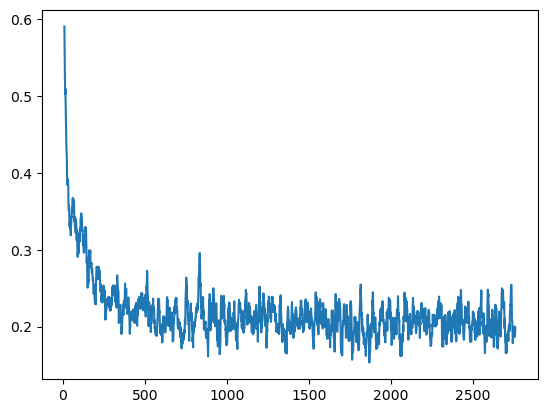

In [10]:
import pandas as pd 
pd.Series(loss_arr).rolling(10).mean().plot()

tensor(0.0004) tensor(1.0000)


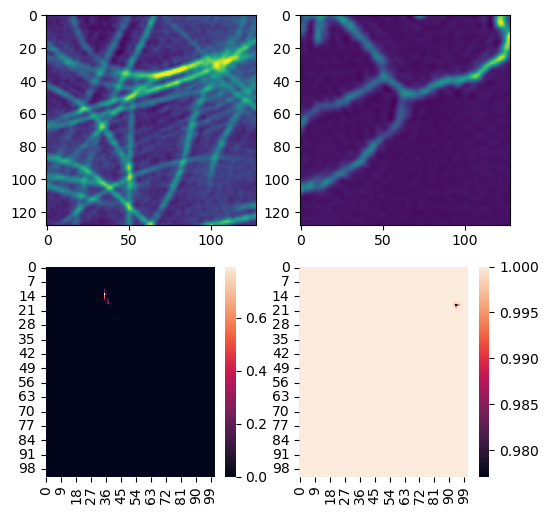

In [21]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
_,ax = plt.subplots(2,2, figsize=(6,6))
idx1 = np.random.randint(0, batch_size)
idx2 = np.random.randint(0, batch_size) + batch_size
ax[0,0].imshow(tar[idx1,0])
ax[0,1].imshow(tar[idx2-batch_size,1])
sns.heatmap(pred[idx1,0].cpu().numpy(), ax=ax[1,0])
sns.heatmap(pred[idx2,0].cpu().numpy(),ax=ax[1,1])
print(pred[idx1,0].mean(), pred[idx2,0].mean())

In [22]:
patch = '/home/ubuntu/ashesh/training/disentangle/texture_classifier.pth'
torch.save(model.state_dict(), patch)
